# Guided Project: Building a Spam Filter with Naive Bayes
### Introduction

In this guided project, I used the Naive Bayes algorithm to build a spam filter for SMS messages that classifies new messages with an accuracy greater than 80%. To train the computer to distinguish between spam and non-spam messages, I used the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that were manually classified by humans.

### Data

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from <a href='https://archive.ics.uci.edu/ml/datasets/sms+spam+collection'>The UCI Machine Learning Repository</a>. The data collection process along is described in more details <a href='http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition'>on this page</a>. The authors' papers related to the above-mentioned dataset can be found also by following <a href='http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition'>this link</a>.

### Outcome

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set.

__NB! This project is carried out according to the <a href='https://www.dataquest.io/'>Dataquest</a> instructions.__

## Data Exploration
### Read in the data

In [1]:
import pandas as pd 
import numpy

# enable visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# apply FiveThirtyEight style to matplotlib graphs
plt.style.use('fivethirtyeight')

data = pd.read_csv('SMSSpamCollection',sep='\t',header=None,names=['Label','SMS'])

In [2]:
data.head(10)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


As we see, the dataset has 5572 rows and two columns. There are no Null values.

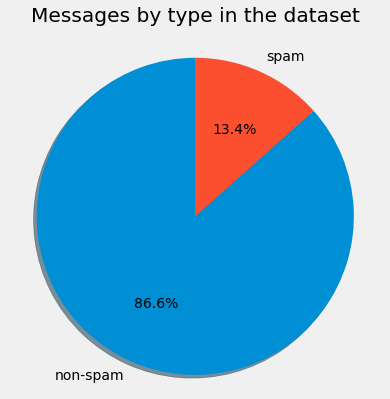

In [4]:
value_dist = data.Label.value_counts(normalize=True)*100

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(value_dist, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Messages by type in the dataset", y = 1.04)
plt.ylabel("")

plt.show()

The graph above displays that almost __87% of the messages__ in the dataset __are ham (non-spam)__, and the remaining __13% are spam__.

## Splitting Dataset Into a Training and a Test Set

Before building the spam filter, it is often helpful to first think of a way of testing how well it works. To test the spam filter, we are first going to __split our dataset into two categories__:

- A __training set__, which we will use to "train" the computer how to classify messages.
- A __test set__, which we will use to test how good the spam filter is with classifying new messages.

We are going to keep __80% of our dataset for training__, and __20% for testing__. The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

Since our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so __we expect that more than 80% of the "new messages" from a test set will be classified correctly as spam or ham (non-spam).__

We are going to __start by randomizing the entire dataset__ to ensure that spam and ham messages are spread properly throughout the dataset.
### Randomizing the entire dataset

In [5]:
# randomize the dataset
data_randomized = data.sample(frac=1,random_state=1)

# calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# create a training and a test set
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [6]:
# compare distribution of values in training and test sets
value_dist_training = training_set.Label.value_counts(normalize=True)*100
value_dist_test = test_set.Label.value_counts(normalize=True)*100

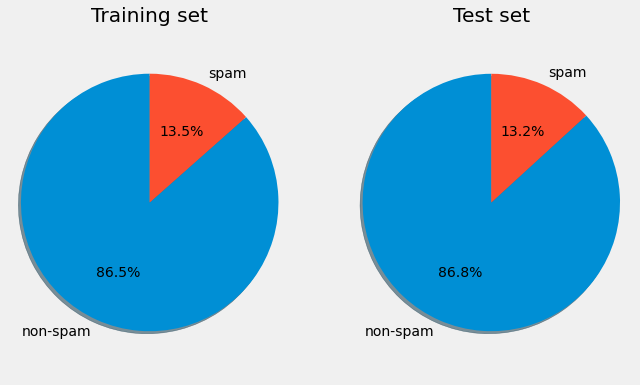

In [7]:
# display distribution of values in training and test sets
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.pie(value_dist_training, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
ax1.title.set_text('Training set')

ax2 = fig.add_subplot(1,2,2)
ax2.pie(value_dist_test, labels=['non-spam','spam'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')
ax2.title.set_text('Test set')

As wee see, both a test set and a training set have similar distribution of values. Thus, __all the assumptions that we will infer from data in the training set must be valid for data from the test set too.__
## Data Cleaning
The next big step is to use the training set to teach the algorithm to classify new messages. __For our Naive Bayes algorithm to be able to make the classification, we will__ first need to perform a bit of data cleaning to __bring the data in a format that will allow us to extract easily all the information we need__.

In particular, we want bring the data to this format:

![](pic1.png)


### Letter case and punctuation
We will begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [8]:
# data before cleaning
training_set.head(7)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...
5,ham,Ok i thk i got it. Then u wan me 2 come now or...
6,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...


In [9]:
# remove remove all the punctuation, leading and trailing spaces and convert string to lowercase
training_set['SMS'] = training_set['SMS'].str.replace('\W',' ').str.lower()
training_set['SMS'] = training_set['SMS'].str.replace('\s+',' ').str.strip()

# data after cleaning
training_set.head(7)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on da...
5,ham,ok i thk i got it then u wan me 2 come now or wat
6,ham,i want kfc its tuesday only buy 2 meals only 2...


### Creating a vocabulary
Now we will create a vocabulary for the messages in the training set. The vocabulary will be a list containing all the unique words across all messages, where each word is represented as a string.

In [10]:
# transform each message from the SMS column into a list of words
training_set['SMS'] = training_set['SMS'].str.split(" ")

In [11]:
vocabulary = []

for row in training_set['SMS']:
    for word in row:
        vocabulary.append(word)

# remove the duplicates from the vocabulary list
vocabulary = list(set(vocabulary))

In [12]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}
                             
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1                             

In [13]:
word_counts = pd.DataFrame(data=word_counts_per_sms) 
word_counts = word_counts.drop("",axis=1)
word_counts

,renting,swell,slob,rupaul,age16,8883,theacusations,indicate,urgh,affections,...,nature,bstfrnd,30pm,goodnoon,traffic,cause,hv,often,rebtel,recieve
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
training_data_clean = pd.concat([training_set, word_counts], axis=1)
training_data_clean.head()

,Label,SMS,renting,swell,slob,rupaul,age16,8883,theacusations,indicate,...,nature,bstfrnd,30pm,goodnoon,traffic,cause,hv,often,rebtel,recieve
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating constants
Now that we are done with data cleaning and have a training set to work with, we can begin creating the spam filter. 
As we know, the Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:

![](pic2.png)
Also, to calculate $\ P(w_i|Spam)$ and $\ P(w_i|Ham)$ inside the formulas above, we need to use these equations:
![](pic3.png)
- $\ N_{Spam}$ is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
- $\ N_{Ham}$ is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.
- $\ N_{Vocabulary}$ is equal to the number of unique words.

We will also use Laplace smoothing and set $\ α=1$. 



In [15]:
# isolate spam and ham messages 
spam_messages = training_data_clean[training_data_clean['Label'] == 'spam']
ham_messages = training_data_clean[training_data_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_data_clean)
p_ham = len(ham_messages) / len(training_data_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters
Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:
$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

In [16]:
vocabulary.remove('')

# Calculate parameters
parameters_spam = {word: ((spam_messages[word].sum()+1)/(n_spam+n_vocabulary)) for word in vocabulary}
parameters_ham = {word: ((ham_messages[word].sum()+1)/(n_ham+n_vocabulary)) for word in vocabulary}

## Classifying A New Message
Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:
- Takes in as input a new message (w$_1$, w$_2$, ..., w$_n$) 
- Calculates P(Spam|w$_1$, w$_2$, ..., w$_n$) and P(Ham|w$_1$, w$_2$, ..., w$_n$).
- Compares the values of P(Spam|w$_1$, w$_2$, ..., w$_n$) and P(Ham|w$_1$, w$_2$, ..., w$_n$), and:
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) > P(Spam|w$_1$, w$_2$, ..., w$_n$), then the message is classified as ham.
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) < P(Spam|w$_1$, w$_2$, ..., w$_n$), then the message is classified as spam.
    - If P(Ham|w$_1$, w$_2$, ..., w$_n$) = P(Spam|w$_1$, w$_2$, ..., w$_n$), then the algorithm may request human help.

In [17]:
import re 

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham 
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now we can test our function _classify( )_ with one spam and one non-spam message.

In [18]:
# test function with a spam message
message_spam = "WINNER!! This is the secret code to unlock the money: C3421."
print(classify(message_spam))

spam


In [19]:
# test function with a ham message
message_ham = "Sounds good, Tom, then see u there"
classify(message_ham)

'ham'

As we can see, the function works correctly. Now __we will validate it and check its accuracy on the test set__. In particular, we will apply the function to the _SMS_ column in the test set and save its output in a new column called _predicted_. Than we will compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. 

To make the measurement, we will use __accuracy__ as a metric:

![](pic4.png)

In [20]:
# apply function to the test set
test_set['predicted'] = test_set['SMS'].apply(classify)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [21]:
correct = test_set.Label == test_set.predicted
print("Correct: {}".format(correct.sum()))
print("Incorrect {}".format(len(test_set)-correct.sum()))
print("Accuracy: {}".format(correct.sum()/len(test_set)*100))

Correct: 1100
Incorrect 14
Accuracy: 98.74326750448833


In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. __The filter had an accuracy of 98.74% on the test set__, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.
## Conclusions

In this guided project we have learnt to:

- Assign probabilities to events based on certain conditions by using conditional probability rules.
- Assign probabilities to events based on whether they are in relationship of statistical independence or not with other events.
- Assign probabilities to events based on prior knowledge by using Bayes' theorem.
- Create a spam filter for SMS messages using the multinomial Naive Bayes algorithm.